Mounted at /content/drive
Загрузка данных...
Токенизация текста...
Создание модели...
Обучение модели...
Epoch 1/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step

Новый лучший F1-score: 0.9281
Модель сохранена (F1-score >= 0.9)
1013/1013 ━━━━━━━━━━━━━━━━━━━━ 90s 77ms/step - accuracy: 0.8318 - loss: 0.4013 - val_accuracy: 0.9210 - val_loss: 0.2170 - val_f1_score: 0.9281
Epoch 2/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step
1013/1013 ━━━━━━━━━━━━━━━━━━━━ 79s 78ms/step - accuracy: 0.9374 - loss: 0.1799 - val_accuracy: 0.9134 - val_loss: 0.2358 - val_f1_score: 0.9229
Epoch 3/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step
1013/1013 ━━━━━━━━━━━━━━━━━━━━ 83s 79ms/step - accuracy: 0.9450 - loss: 0.1629 - val_accuracy: 0.9153 - val_loss: 0.2449 - val_f1_score: 0.9241
Epoch 4/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step
1013/1013 ━━━━━━━━━━━━━━━━━━━━ 82s 79ms/step - accuracy: 0.9524 - loss: 0.1417 - val_accuracy: 0.9144 - val_loss: 0.2610 - val_f1_score: 0.9225
Epoch 5/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 6

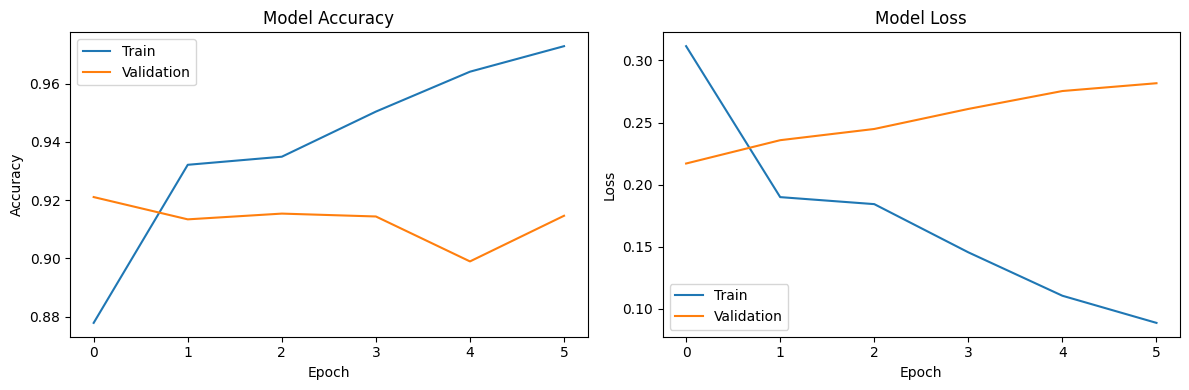

In [ ]:
import json
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Bidirectional, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
import matplotlib.pyplot as plt
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')

dataset_path = "/content/drive/MyDrive/Colab Notebooks/RU_dataset_normalized.json"
tokenizer_path = "/content/drive/MyDrive/Colab Notebooks/tokenizer.pkl"
model_path = "/content/drive/MyDrive/Colab Notebooks/depression_detector.keras"

class F1ScoreCallback(Callback):
    def __init__(self, validation_data):
        super(F1ScoreCallback, self).__init__()
        self.validation_data = validation_data
        self.best_f1 = 0
        self.best_weights = None

    def on_epoch_end(self, epoch, logs=None):
        val_predict = (self.model.predict(self.validation_data[0]) > 0.5).astype(int)
        val_f1 = f1_score(self.validation_data[1], val_predict)
        logs['val_f1_score'] = val_f1

        if val_f1 > self.best_f1:
            self.best_f1 = val_f1
            self.best_weights = self.model.get_weights()
            print(f"\nНовый лучший F1-score: {val_f1:.4f}")

            # Сохраняем модель, если F1-score >= 0.9
            if val_f1 >= 0.9:
                self.model.save("best_model.keras")
                print("Модель сохранена (F1-score >= 0.9)")

def load_and_prepare_data(file_path):
    """Загрузка и подготовка данных"""
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)

    df = pd.DataFrame(data, columns=['text', 'label'])

    # Преобразуем метки в числовой формат
    label_map = {'non-suicide': 0, 'suicide': 1}
    df['label'] = df['label'].map(label_map)

    return df

def create_model(vocab_size, max_length):
    """Создание модели"""
    model = Sequential([
        Embedding(vocab_size, 128),
        Bidirectional(LSTM(64, return_sequences=True)),
        Bidirectional(LSTM(32)),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

def train_model():
    # Загрузка данных
    print("Загрузка данных...")
    df = load_and_prepare_data(dataset_path)

    # Разделение на train и validation
    X_train, X_val, y_train, y_val = train_test_split(
        df['text'], df['label'],
        test_size=0.2,
        random_state=42,
        stratify=df['label']
    )

    # Токенизация текста
    print("Токенизация текста...")
    tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
    tokenizer.fit_on_texts(X_train)

    # Сохранение токенизатора
    import pickle
    with open(tokenizer_path, "wb") as f:
        pickle.dump(tokenizer, f)

    # Преобразование текста в последовательности
    X_train_seq = tokenizer.texts_to_sequences(X_train)
    X_val_seq = tokenizer.texts_to_sequences(X_val)

    # Паддинг последовательностей
    max_length = 500  # Максимальная длина последовательности
    X_train_padded = pad_sequences(X_train_seq, maxlen=max_length, padding='post', truncating='post')
    X_val_padded = pad_sequences(X_val_seq, maxlen=max_length, padding='post', truncating='post')

    # Создание модели
    print("Создание модели...")
    model = create_model(vocab_size=10000, max_length=max_length)

    # Callbacks
    early_stopping = EarlyStopping(
        monitor='val_loss',  # Изменено с val_f1_score на val_loss
        patience=5,
        restore_best_weights=True,
        mode='min'
    )

    f1_callback = F1ScoreCallback(validation_data=(X_val_padded, y_val))

    # Обучение модели
    print("Обучение модели...")
    history = model.fit(
        X_train_padded, y_train,
        epochs=50,
        batch_size=32,
        validation_data=(X_val_padded, y_val),
        callbacks=[early_stopping, f1_callback]
    )

    # Оценка модели
    print("\nОценка модели на валидационных данных:")
    y_pred = (model.predict(X_val_padded) > 0.5).astype(int)
    f1 = f1_score(y_val, y_pred)
    print(f"F1-score: {f1:.4f}")
    print("\nПолный отчет о классификации:")
    print(classification_report(y_val, y_pred))

    # Сохранение модели
    if f1 >= 0.9:
        model.save(model_path)

        print("\nМодель сохранена как 'depression_detector.keras' (F1-score >= 0.9)")
    else:
        print("\nМодель не достигла требуемого F1-score >= 0.9")

    # Построение графиков
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()
    plt.close()

if __name__ == "__main__":
    train_model()

Mounted at /content/drive

Обучение модели: simple
Epoch 1/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
1013/1013 ━━━━━━━━━━━━━━━━━━━━ 54s 44ms/step - accuracy: 0.8340 - loss: 0.3852 - val_accuracy: 0.9161 - val_loss: 0.2485 - val_f1_score: 0.9236
Epoch 2/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step
1013/1013 ━━━━━━━━━━━━━━━━━━━━ 74s 41ms/step - accuracy: 0.9352 - loss: 0.1854 - val_accuracy: 0.9203 - val_loss: 0.2320 - val_f1_score: 0.9261
Epoch 3/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step
1013/1013 ━━━━━━━━━━━━━━━━━━━━ 84s 42ms/step - accuracy: 0.9532 - loss: 0.1418 - val_accuracy: 0.9204 - val_loss: 0.2403 - val_f1_score: 0.9273
Epoch 4/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step
1013/1013 ━━━━━━━━━━━━━━━━━━━━ 80s 41ms/step - accuracy: 0.9560 - loss: 0.1330 - val_accuracy: 0.9057 - val_loss: 0.3242 - val_f1_score: 0.9105
Epoch 5/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step
1013/1013 ━━━━━━━━━━━━━━━━━━━━ 83s 42ms/step - accuracy: 0.9670 - loss: 0.1005 - val_accuracy: 0.9176 - val_

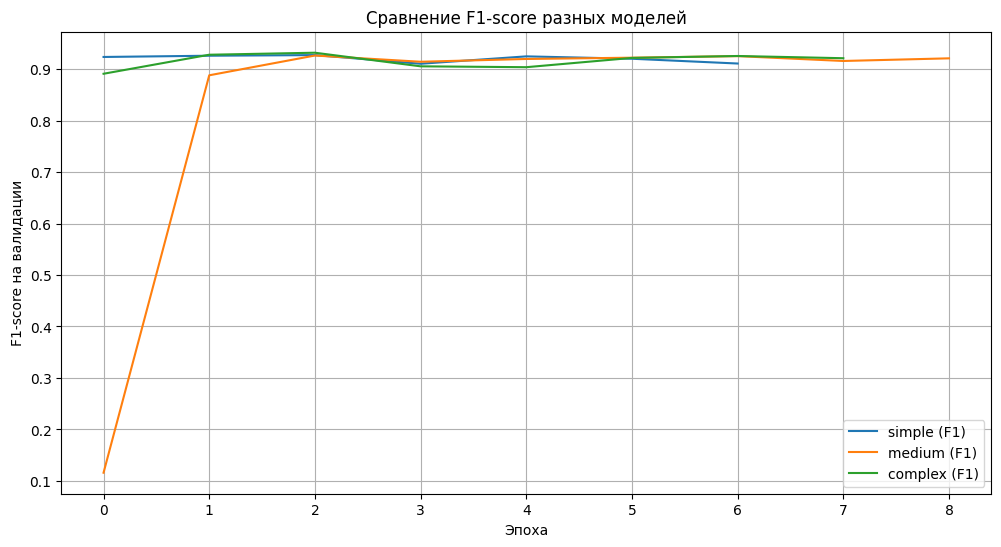

In [ ]:
import json
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Bidirectional, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, Callback
from google.colab import drive

# Монтируем диск
drive.mount('/content/drive')

# Пути
dataset_path = "/content/drive/MyDrive/Colab Notebooks/RU_dataset_normalized.json"
tokenizer_path = "/content/drive/MyDrive/Colab Notebooks/tokenizer.pkl"

# Загрузка данных
def load_and_prepare_data(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    df = pd.DataFrame(data, columns=['text', 'label'])
    label_map = {'non-suicide': 0, 'suicide': 1}
    df['label'] = df['label'].map(label_map)
    return df

# Создание моделей
def create_model(vocab_size, max_length, model_type="simple"):
    model = Sequential()
    model.add(Embedding(vocab_size, 128))

    if model_type == "simple":
        model.add(Bidirectional(LSTM(32)))
    elif model_type == "medium":
        model.add(Bidirectional(LSTM(64, return_sequences=True)))
        model.add(Bidirectional(LSTM(32)))
    elif model_type == "complex":
        model.add(Bidirectional(LSTM(64, return_sequences=True)))
        model.add(Bidirectional(LSTM(64, return_sequences=True)))
        model.add(Bidirectional(LSTM(32)))

    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# Специальный callback для отслеживания F1-score
class F1ScoreCallback(Callback):
    def __init__(self, validation_data):
        super().__init__()
        self.validation_data = validation_data
        self.history = []

    def on_epoch_end(self, epoch, logs=None):
        val_predict = (self.model.predict(self.validation_data[0]) > 0.5).astype(int)
        val_f1 = f1_score(self.validation_data[1], val_predict)
        logs['val_f1_score'] = val_f1
        self.history.append(val_f1)

# Основной код
def train_and_evaluate():
    df = load_and_prepare_data(dataset_path)

    # Разделение данных
    X_train, X_val, y_train, y_val = train_test_split(df['text'], df['label'], test_size=0.2, random_state=42, stratify=df['label'])

    # Токенизация
    tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
    tokenizer.fit_on_texts(X_train)

    # Сохраняем токенизатор
    with open(tokenizer_path, "wb") as f:
        pickle.dump(tokenizer, f)

    # Последовательности
    X_train_seq = tokenizer.texts_to_sequences(X_train)
    X_val_seq = tokenizer.texts_to_sequences(X_val)
    max_length = 500
    X_train_padded = pad_sequences(X_train_seq, maxlen=max_length, padding='post', truncating='post')
    X_val_padded = pad_sequences(X_val_seq, maxlen=max_length, padding='post', truncating='post')

    # Параметры моделей
    model_types = ['simple', 'medium', 'complex']
    histories = {}
    f1_histories = {}

    for model_type in model_types:
        print(f"\nОбучение модели: {model_type}")
        model = create_model(vocab_size=10000, max_length=max_length, model_type=model_type)

        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, mode='min')
        f1_callback = F1ScoreCallback(validation_data=(X_val_padded, y_val))

        history = model.fit(
            X_train_padded, y_train,
            epochs=50,
            batch_size=32,
            validation_data=(X_val_padded, y_val),
            callbacks=[early_stopping, f1_callback],
            verbose=1
        )

        histories[model_type] = history
        f1_histories[model_type] = f1_callback.history

    # Построение графиков сравнения
    plt.figure(figsize=(12, 6))
    for model_type in model_types:
        plt.plot(f1_histories[model_type], label=f"{model_type} (F1)")
    plt.title('Сравнение F1-score разных моделей')
    plt.xlabel('Эпоха')
    plt.ylabel('F1-score на валидации')
    plt.legend()
    plt.grid()
    plt.show()

if __name__ == "__main__":
    train_and_evaluate()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Обучение модели с оптимизатором: Adam
Epoch 1/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step
1013/1013 ━━━━━━━━━━━━━━━━━━━━ 90s 81ms/step - accuracy: 0.8327 - loss: 0.3995 - val_accuracy: 0.9141 - val_loss: 0.2339 - val_f1_score: 0.9240
Epoch 2/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step
1013/1013 ━━━━━━━━━━━━━━━━━━━━ 138s 80ms/step - accuracy: 0.9294 - loss: 0.1910 - val_accuracy: 0.8697 - val_loss: 0.3333 - val_f1_score: 0.8709
Epoch 3/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step
1013/1013 ━━━━━━━━━━━━━━━━━━━━ 79s 77ms/step - accuracy: 0.9496 - loss: 0.1502 - val_accuracy: 0.9183 - val_loss: 0.2536 - val_f1_score: 0.9254
Epoch 4/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step
1013/1013 ━━━━━━━━━━━━━━━━━━━━ 73s 72ms/step - accuracy: 0.9611 - loss: 0.1165 - val_accuracy: 0.9134 - val_loss: 0.2798 - val_f1_score: 0.9203
Epoch 5/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 6s 

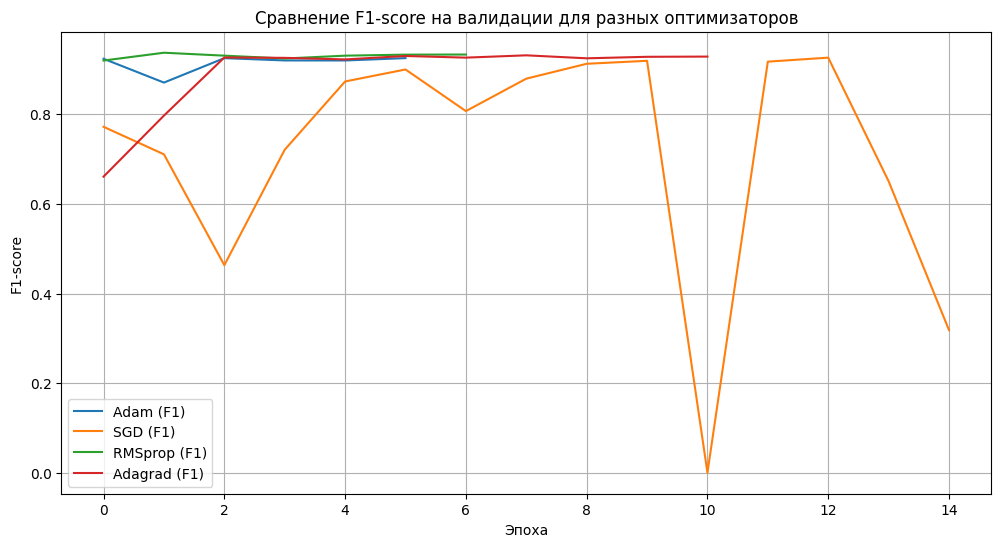

In [ ]:
import json
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Bidirectional, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, Callback
from google.colab import drive

# Монтируем диск
drive.mount('/content/drive')

# Пути
dataset_path = "/content/drive/MyDrive/Colab Notebooks/RU_dataset_normalized.json"
tokenizer_path = "/content/drive/MyDrive/Colab Notebooks/tokenizer.pkl"

# Загрузка данных
def load_and_prepare_data(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    df = pd.DataFrame(data, columns=['text', 'label'])
    label_map = {'non-suicide': 0, 'suicide': 1}
    df['label'] = df['label'].map(label_map)
    return df

# Создание модели
def create_medium_model(vocab_size, max_length, optimizer):
    model = Sequential()
    model.add(Embedding(vocab_size, 128))
    model.add(Bidirectional(LSTM(64, return_sequences=True)))
    model.add(Bidirectional(LSTM(32)))
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# Специальный callback для отслеживания F1-score
class F1ScoreCallback(Callback):
    def __init__(self, validation_data):
        super().__init__()
        self.validation_data = validation_data
        self.history = []

    def on_epoch_end(self, epoch, logs=None):
        val_predict = (self.model.predict(self.validation_data[0]) > 0.5).astype(int)
        val_f1 = f1_score(self.validation_data[1], val_predict)
        logs['val_f1_score'] = val_f1
        self.history.append(val_f1)

# Основной код
def train_with_optimizers():
    df = load_and_prepare_data(dataset_path)

    # Разделение данных
    X_train, X_val, y_train, y_val = train_test_split(df['text'], df['label'], test_size=0.2, random_state=42, stratify=df['label'])

    # Токенизация
    tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
    tokenizer.fit_on_texts(X_train)

    # Сохраняем токенизатор
    with open(tokenizer_path, "wb") as f:
        pickle.dump(tokenizer, f)

    # Последовательности
    X_train_seq = tokenizer.texts_to_sequences(X_train)
    X_val_seq = tokenizer.texts_to_sequences(X_val)
    max_length = 500
    X_train_padded = pad_sequences(X_train_seq, maxlen=max_length, padding='post', truncating='post')
    X_val_padded = pad_sequences(X_val_seq, maxlen=max_length, padding='post', truncating='post')

    # Список оптимизаторов
    optimizers = {
        'Adam': tf.keras.optimizers.Adam(learning_rate=0.001),
        'SGD': tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
        'RMSprop': tf.keras.optimizers.RMSprop(learning_rate=0.001),
        'Adagrad': tf.keras.optimizers.Adagrad(learning_rate=0.01)
    }

    histories = {}
    f1_histories = {}

    for opt_name, opt in optimizers.items():
        print(f"\nОбучение модели с оптимизатором: {opt_name}")
        model = create_medium_model(vocab_size=10000, max_length=max_length, optimizer=opt)

        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, mode='min')
        f1_callback = F1ScoreCallback(validation_data=(X_val_padded, y_val))

        history = model.fit(
            X_train_padded, y_train,
            epochs=50,
            batch_size=32,
            validation_data=(X_val_padded, y_val),
            callbacks=[early_stopping, f1_callback],
            verbose=1
        )

        histories[opt_name] = history
        f1_histories[opt_name] = f1_callback.history

    # Построение графиков сравнения F1
    plt.figure(figsize=(12, 6))
    for opt_name in optimizers.keys():
        plt.plot(f1_histories[opt_name], label=f"{opt_name} (F1)")
    plt.title('Сравнение F1-score на валидации для разных оптимизаторов')
    plt.xlabel('Эпоха')
    plt.ylabel('F1-score')
    plt.legend()
    plt.grid()
    plt.show()

if __name__ == "__main__":
    train_with_optimizers()


In [ ]:
import json
import pandas as pd
import numpy as np
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')

def analyze_text_lengths(df, n=15):
    """
    Анализирует самые длинные и самые короткие тексты в датасете

    Args:
        df: DataFrame с текстами
        n: количество текстов для вывода
    """
    # Создаем копию DataFrame с длиной текстов
    df_with_length = df.copy()
    df_with_length['text_length'] = df_with_length['text'].str.len()

    # Получаем самые длинные тексты
    longest_texts = df_with_length.nlargest(n, 'text_length')
    print(f"\n{n} самых длинных текстов:")
    print("-" * 50)
    for idx, row in longest_texts.iterrows():
        print(f"\nДлина: {row['text_length']} символов")
        print(f"Класс: {row['label']}")
        print(f"Текст: {row['text'][:200]}...")  # Показываем только первые 200 символов

    # Получаем самые короткие тексты
    shortest_texts = df_with_length.nsmallest(n, 'text_length')
    print(f"\n{n} самых коротких текстов:")
    print("-" * 50)
    for idx, row in shortest_texts.iterrows():
        print(f"\nДлина: {row['text_length']} символов")
        print(f"Класс: {row['label']}")
        print(f"Текст: {row['text']}")

def analyze_dataset(file_path):
    # Читаем JSON файл
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)

    # Преобразуем в DataFrame с правильными названиями колонок
    df = pd.DataFrame(data, columns=['text', 'label'])

    # Выводим информацию о структуре данных
    print("\nИнформация о датасете:")
    print("-" * 50)
    print(df.info())

    # Анализ распределения классов
    print("\nРаспределение классов:")
    print("-" * 50)
    class_distribution = df['label'].value_counts()
    total = len(df)

    for label, count in class_distribution.items():
        percentage = round((count / total * 100), 2)
        print(f"Класс '{label}': {count} текстов ({percentage}%)")

    # Дополнительная статистика
    print("\nСтатистика по длине текстов:")
    print("-" * 50)
    df['text_length'] = df['text'].str.len()
    print(f"Средняя длина текста: {round(df['text_length'].mean(), 2)} символов")
    print(f"Минимальная длина: {df['text_length'].min()} символов")
    print(f"Максимальная длина: {df['text_length'].max()} символов")

    # Статистика по классам
    print("\nСтатистика по классам:")
    print("-" * 50)
    class_stats = df.groupby('label')['text_length'].agg(['mean', 'min', 'max'])
    print(class_stats.round(2))

    # Анализ самых длинных и самых коротких текстов
    analyze_text_lengths(df)

dataset_path = "/content/drive/MyDrive/Colab Notebooks/RU_dataset_normalized.json"
if __name__ == "__main__":
    #file_path = "RU_dataset.json"
    file_path = dataset_path
    analyze_dataset(file_path)

Mounted at /content/drive

Информация о датасете:
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40515 entries, 0 to 40514
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    40515 non-null  object
 1   label   40515 non-null  object
dtypes: object(2)
memory usage: 633.2+ KB
None

Распределение классов:
--------------------------------------------------
Класс 'suicide': 22340 текстов (55.14%)
Класс 'non-suicide': 18175 текстов (44.86%)

Статистика по длине текстов:
--------------------------------------------------
Средняя длина текста: 722.03 символов
Минимальная длина: 100 символов
Максимальная длина: 5000 символов

Статистика по классам:
--------------------------------------------------
               mean  min   max
label                         
non-suicide  388.79  100  4913
suicide      993.14  100  5000

15 самых длинных текстов:
------------------------------

In [ ]:
import json
import pandas as pd
import numpy as np
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')

def analyze_text_lengths(df, n=15):
    """
    Анализирует самые длинные и самые короткие тексты в датасете

    Args:
        df: DataFrame с текстами
        n: количество текстов для вывода
    """
    # Создаем копию DataFrame с длиной текстов
    df_with_length = df.copy()
    df_with_length['text_length'] = df_with_length['text'].str.len()

    # Получаем самые длинные тексты
    longest_texts = df_with_length.nlargest(n, 'text_length')
    print(f"\n{n} самых длинных текстов:")
    print("-" * 50)
    for idx, row in longest_texts.iterrows():
        print(f"\nДлина: {row['text_length']} символов")
        print(f"Класс: {row['label']}")
        print(f"Текст: {row['text'][:200]}...")  # Показываем только первые 200 символов

    # Получаем самые короткие тексты
    shortest_texts = df_with_length.nsmallest(n, 'text_length')
    print(f"\n{n} самых коротких текстов:")
    print("-" * 50)
    for idx, row in shortest_texts.iterrows():
        print(f"\nДлина: {row['text_length']} символов")
        print(f"Класс: {row['label']}")
        print(f"Текст: {row['text']}")

def analyze_dataset(file_path):
    # Читаем JSON файл
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)

    # Преобразуем в DataFrame с правильными названиями колонок
    df = pd.DataFrame(data, columns=['text', 'label'])

    # Выводим информацию о структуре данных
    print("\nИнформация о датасете:")
    print("-" * 50)
    print(df.info())

    # Анализ распределения классов
    print("\nРаспределение классов:")
    print("-" * 50)
    class_distribution = df['label'].value_counts()
    total = len(df)

    for label, count in class_distribution.items():
        percentage = round((count / total * 100), 2)
        print(f"Класс '{label}': {count} текстов ({percentage}%)")

    # Дополнительная статистика
    print("\nСтатистика по длине текстов:")
    print("-" * 50)
    df['text_length'] = df['text'].str.len()
    print(f"Средняя длина текста: {round(df['text_length'].mean(), 2)} символов")
    print(f"Минимальная длина: {df['text_length'].min()} символов")
    print(f"Максимальная длина: {df['text_length'].max()} символов")

    # Статистика по классам
    print("\nСтатистика по классам:")
    print("-" * 50)
    class_stats = df.groupby('label')['text_length'].agg(['mean', 'min', 'max'])
    print(class_stats.round(2))

    # Анализ самых длинных и самых коротких текстов
    analyze_text_lengths(df)

dataset_path = "/content/drive/MyDrive/Colab Notebooks/RU_dataset.json"
if __name__ == "__main__":
    #file_path = "RU_dataset.json"
    file_path = dataset_path
    analyze_dataset(file_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Информация о датасете:
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47997 entries, 0 to 47996
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    47997 non-null  object
 1   label   47997 non-null  object
dtypes: object(2)
memory usage: 750.1+ KB
None

Распределение классов:
--------------------------------------------------
Класс 'non-suicide': 24081 текстов (50.17%)
Класс 'suicide': 23916 текстов (49.83%)

Статистика по длине текстов:
--------------------------------------------------
Средняя длина текста: 732.67 символов
Минимальная длина: 3 символов
Максимальная длина: 39730 символов

Статистика по классам:
--------------------------------------------------
                mean  min    max
label                           
non-suicide  

In [ ]:
import json
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle
from google.colab import drive

# Монтируем Google Диск
drive.mount('/content/drive')
model_path = "/content/drive/MyDrive/Colab Notebooks/depression_detector.keras"
tokenizer_path = "/content/drive/MyDrive/Colab Notebooks/tokenizer.pkl"

def load_model_and_tokenizer():
    """Загрузка модели и токенизатора"""
    model = tf.keras.models.load_model(model_path)
    with open(tokenizer_path, "rb") as f:
        tokenizer = pickle.load(f)
    return model, tokenizer

def predict_text(text, model, tokenizer, max_length=500):
    """Предсказание для одного текста"""
    # Токенизация и паддинг
    sequence = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(sequence, maxlen=max_length, padding='post', truncating='post')

    # Предсказание
    prediction = model.predict(padded)[0][0]
    return prediction

def main():
    # Загрузка модели и токенизатора
    print("Загрузка модели и токенизатора...")
    model, tokenizer = load_model_and_tokenizer()

    while True:
        # Получение текста от пользователя
        text = input("\nВведите текст для анализа (или 'q' для выхода): ")
        if text.lower() == 'q':
            break

        # Предсказание
        prediction = predict_text(text, model, tokenizer)

        # Вывод результата
        print("\nРезультат анализа:")
        print(f"Вероятность депрессивного текста: {prediction:.2%}")
        print(f"Класс: {'Депрессивный' if prediction > 0.5 else 'Не депрессивный'}")

if __name__ == "__main__":
    main()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Загрузка модели и токенизатора...

Введите текст для анализа (или 'q' для выхода): жизнь не имеет смысла
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step

Результат анализа:
Вероятность депрессивного текста: 50.01%
Класс: Депрессивный

Введите текст для анализа (или 'q' для выхода): я знаю пароль я вижу орентир
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step

Результат анализа:
Вероятность депрессивного текста: 13.46%
Класс: Не депрессивный

Введите текст для анализа (или 'q' для выхода): я не могу вспомнить пароль
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step

Результат анализа:
Вероятность депрессивного текста: 9.33%
Класс: Не депрессивный

Введите текст для анализа (или 'q' для выхода): можно ли считать подписку на короля и шута самоубийством?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step

Результат анализа:
Вероятность депрессивного текста: 34.28%
Класс: Не депрессивный

Введите текст для а

In [ ]:
import json
import pandas as pd
import numpy as np
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')

def analyze_text_lengths(df, n=15):
    """
    Анализирует самые длинные и самые короткие тексты в датасете

    Args:
        df: DataFrame с текстами
        n: количество текстов для вывода
    """
    # Создаем копию DataFrame с длиной текстов
    df_with_length = df.copy()
    df_with_length['text_length'] = df_with_length['text'].str.len()

    # Получаем самые длинные тексты
    longest_texts = df_with_length.nlargest(n, 'text_length')
    print(f"\n{n} самых длинных текстов:")
    print("-" * 50)
    for idx, row in longest_texts.iterrows():
        print(f"\nДлина: {row['text_length']} символов")
        print(f"Класс: {row['label']}")
        print(f"Текст: {row['text'][:200]}...")  # Показываем только первые 200 символов

    # Получаем самые короткие тексты
    shortest_texts = df_with_length.nsmallest(n, 'text_length')
    print(f"\n{n} самых коротких текстов:")
    print("-" * 50)
    for idx, row in shortest_texts.iterrows():
        print(f"\nДлина: {row['text_length']} символов")
        print(f"Класс: {row['label']}")
        print(f"Текст: {row['text']}")

def analyze_dataset(file_path):
    # Читаем JSON файл
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)

    # Преобразуем в DataFrame с правильными названиями колонок
    df = pd.DataFrame(data, columns=['text', 'label'])

    # Выводим информацию о структуре данных
    print("\nИнформация о датасете:")
    print("-" * 50)
    print(df.info())

    # Анализ распределения классов
    print("\nРаспределение классов:")
    print("-" * 50)
    class_distribution = df['label'].value_counts()
    total = len(df)

    for label, count in class_distribution.items():
        percentage = round((count / total * 100), 2)
        print(f"Класс '{label}': {count} текстов ({percentage}%)")

    # Дополнительная статистика
    print("\nСтатистика по длине текстов:")
    print("-" * 50)
    df['text_length'] = df['text'].str.len()
    print(f"Средняя длина текста: {round(df['text_length'].mean(), 2)} символов")
    print(f"Минимальная длина: {df['text_length'].min()} символов")
    print(f"Максимальная длина: {df['text_length'].max()} символов")

    # Статистика по классам
    print("\nСтатистика по классам:")
    print("-" * 50)
    class_stats = df.groupby('label')['text_length'].agg(['mean', 'min', 'max'])
    print(class_stats.round(2))

    # Анализ самых длинных и самых коротких текстов
    analyze_text_lengths(df)

dataset_path = "/content/drive/MyDrive/Colab Notebooks/Depressive data.json"
if __name__ == "__main__":
    #file_path = "RU_dataset.json"
    file_path = dataset_path
    analyze_dataset(file_path)

Mounted at /content/drive

Информация о датасете:
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64039 entries, 0 to 64038
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    64039 non-null  object
 1   label   64039 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1000.7+ KB
None

Распределение классов:
--------------------------------------------------
Класс '0': 32021 текстов (50.0%)
Класс '1': 32018 текстов (50.0%)

Статистика по длине текстов:
--------------------------------------------------
Средняя длина текста: 1082.49 символов
Минимальная длина: 1.0 символов
Максимальная длина: 19919.0 символов

Статистика по классам:
--------------------------------------------------
          mean  min      max
label                       
0      1414.13  5.0  19790.0
1       750.84  1.0  19919.0

15 самых длинных текстов:
-----------------------------------------

In [ ]:
import json
import pandas as pd
import numpy as np
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')

def analyze_text_lengths(df, n=15):
    """
    Анализирует самые длинные и самые короткие тексты в датасете

    Args:
        df: DataFrame с текстами
        n: количество текстов для вывода
    """
    # Создаем копию DataFrame с длиной текстов
    df_with_length = df.copy()
    df_with_length['text_length'] = df_with_length['text'].str.len()

    # Получаем самые длинные тексты
    longest_texts = df_with_length.nlargest(n, 'text_length')
    print(f"\n{n} самых длинных текстов:")
    print("-" * 50)
    for idx, row in longest_texts.iterrows():
        print(f"\nДлина: {row['text_length']} символов")
        print(f"Класс: {row['label']}")
        print(f"Текст: {row['text'][:200]}...")  # Показываем только первые 200 символов

    # Получаем самые короткие тексты
    shortest_texts = df_with_length.nsmallest(n, 'text_length')
    print(f"\n{n} самых коротких текстов:")
    print("-" * 50)
    for idx, row in shortest_texts.iterrows():
        print(f"\nДлина: {row['text_length']} символов")
        print(f"Класс: {row['label']}")
        print(f"Текст: {row['text']}")

def analyze_dataset(file_path):
    # Читаем JSON файл
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)

    # Преобразуем в DataFrame с правильными названиями колонок
    df = pd.DataFrame(data, columns=['text', 'label'])

    # Выводим информацию о структуре данных
    print("\nИнформация о датасете:")
    print("-" * 50)
    print(df.info())

    # Анализ распределения классов
    print("\nРаспределение классов:")
    print("-" * 50)
    class_distribution = df['label'].value_counts()
    total = len(df)

    for label, count in class_distribution.items():
        percentage = round((count / total * 100), 2)
        print(f"Класс '{label}': {count} текстов ({percentage}%)")

    # Дополнительная статистика
    print("\nСтатистика по длине текстов:")
    print("-" * 50)
    df['text_length'] = df['text'].str.len()
    print(f"Средняя длина текста: {round(df['text_length'].mean(), 2)} символов")
    print(f"Минимальная длина: {df['text_length'].min()} символов")
    print(f"Максимальная длина: {df['text_length'].max()} символов")

    # Статистика по классам
    print("\nСтатистика по классам:")
    print("-" * 50)
    class_stats = df.groupby('label')['text_length'].agg(['mean', 'min', 'max'])
    print(class_stats.round(2))

    # Анализ самых длинных и самых коротких текстов
    analyze_text_lengths(df)

dataset_path = "/content/drive/MyDrive/Colab Notebooks/Depressive data_normalized.json"
if __name__ == "__main__":
    #file_path = "RU_dataset.json"
    file_path = dataset_path
    analyze_dataset(file_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Информация о датасете:
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55499 entries, 0 to 55498
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    55499 non-null  object
 1   label   55499 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 867.3+ KB
None

Распределение классов:
--------------------------------------------------
Класс '0': 29171 текстов (52.56%)
Класс '1': 26328 текстов (47.44%)

Статистика по длине текстов:
--------------------------------------------------
Средняя длина текста: 923.42 символов
Минимальная длина: 100 символов
Максимальная длина: 4999 символов

Статистика по классам:
--------------------------------------------------
          mean  min   max
label                    
0      1034.28  100  4999
1     

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Загрузка модели и токенизатора...
Загрузка тестового датасета...
Подготовка данных...
Оценка модели на тестовом наборе...
1735/1735 ━━━━━━━━━━━━━━━━━━━━ 44s 24ms/step

Классификационный отчет:
              precision    recall  f1-score       support
Non-suicidal   0.774827  0.991224  0.869768  29171.000000
Suicidal       0.985919  0.680834  0.805455  26328.000000
accuracy       0.843979  0.843979  0.843979      0.843979
macro avg      0.880373  0.836029  0.837612  55499.000000
weighted avg   0.874967  0.843979  0.839259  55499.000000


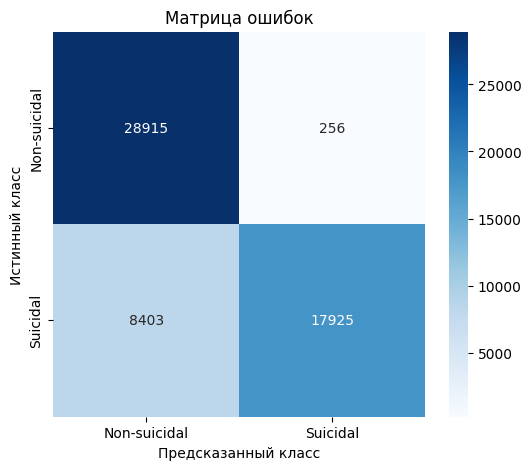

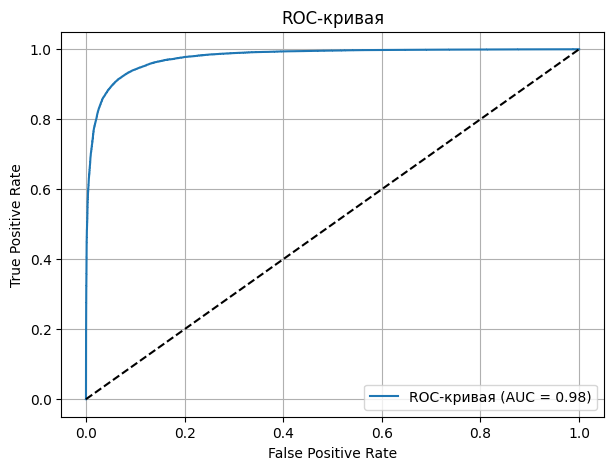

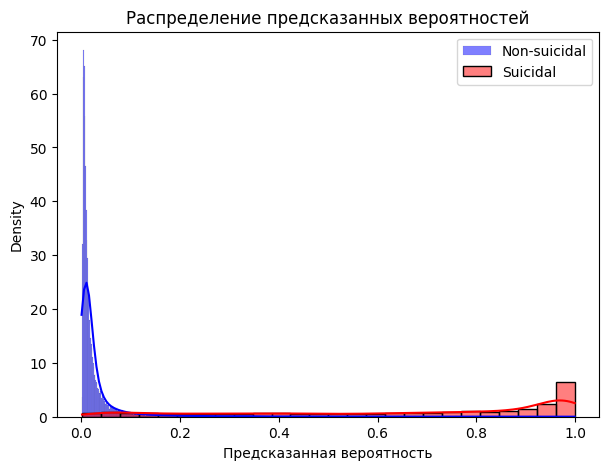

In [ ]:
import json
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

from google.colab import drive

# Монтируем Google Диск
drive.mount('/content/drive')

# Пути к файлам
model_path = "/content/drive/MyDrive/Colab Notebooks/depression_detector.keras"
tokenizer_path = "/content/drive/MyDrive/Colab Notebooks/tokenizer.pkl"
test_dataset_path = "/content/drive/MyDrive/Colab Notebooks/Depressive data_normalized.json"  # Путь к тестовому датасету

def load_model_and_tokenizer():
    """Загрузка модели и токенизатора"""
    model = tf.keras.models.load_model(model_path)
    with open(tokenizer_path, "rb") as f:
        tokenizer = pickle.load(f)
    return model, tokenizer

def load_test_data(file_path):
    """Загрузка тестового набора"""
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    df = pd.DataFrame(data, columns=['text', 'label'])
    return df

def prepare_data(df, tokenizer, max_length=500):
    """Токенизация и паддинг"""
    sequences = tokenizer.texts_to_sequences(df['text'])
    padded = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')
    return padded

def evaluate_model(model, X_test, y_test):
    """Оценка модели и построение визуализаций"""
    y_pred_probs = model.predict(X_test).flatten()
    y_pred = (y_pred_probs > 0.5).astype(int)

    # Классификационный отчет
    report = classification_report(y_test, y_pred, target_names=['Non-suicidal', 'Suicidal'], output_dict=True)
    report_df = pd.DataFrame(report).transpose()

    print("\nКлассификационный отчет:")
    print(report_df)

    # Матрица ошибок
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-suicidal', 'Suicidal'], yticklabels=['Non-suicidal', 'Suicidal'])
    plt.xlabel('Предсказанный класс')
    plt.ylabel('Истинный класс')
    plt.title('Матрица ошибок')
    plt.show()

    # ROC-кривая
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(7,5))
    plt.plot(fpr, tpr, label=f'ROC-кривая (AUC = {roc_auc:.2f})')
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

    # Распределение вероятностей
    plt.figure(figsize=(7,5))
    sns.histplot(y_pred_probs[y_test==0], color='blue', label='Non-suicidal', kde=True, stat="density")
    sns.histplot(y_pred_probs[y_test==1], color='red', label='Suicidal', kde=True, stat="density")
    plt.xlabel('Предсказанная вероятность')
    plt.title('Распределение предсказанных вероятностей')
    plt.legend()
    plt.show()

def main():
    # Загрузка модели и токенизатора
    print("Загрузка модели и токенизатора...")
    model, tokenizer = load_model_and_tokenizer()

    # Загрузка тестового набора
    print("Загрузка тестового датасета...")
    df_test = load_test_data(test_dataset_path)

    # Подготовка данных
    print("Подготовка данных...")
    X_test = prepare_data(df_test, tokenizer)
    y_test = df_test['label'].values

    # Оценка модели
    print("Оценка модели на тестовом наборе...")
    evaluate_model(model, X_test, y_test)

if __name__ == "__main__":
    main()


Mounted at /content/drive
Загрузка модели и токенизатора...
Загрузка тестового датасета...

Оставлено 38541 текстов: 9392 с ключевыми словами и 29171 нейтральных.
Подготовка данных...
Оценка модели на тестовом наборе...
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 31s 24ms/step

Классификационный отчет:
              precision    recall  f1-score       support
Non-suicidal   0.957228  0.991224  0.973930  29171.000000
Suicidal       0.969282  0.862113  0.912562   9370.000000
accuracy       0.959835  0.959835  0.959835      0.959835
macro avg      0.963255  0.926669  0.943246  38541.000000
weighted avg   0.960159  0.959835  0.959010  38541.000000


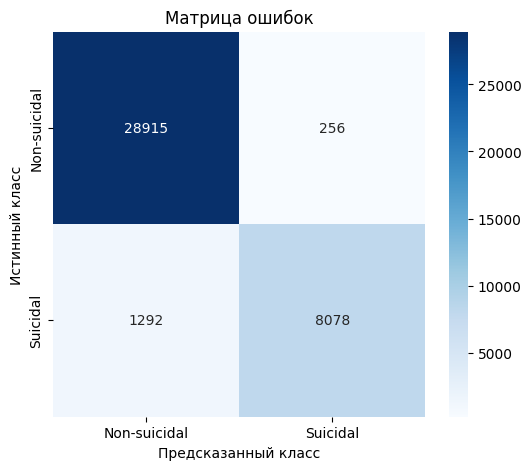

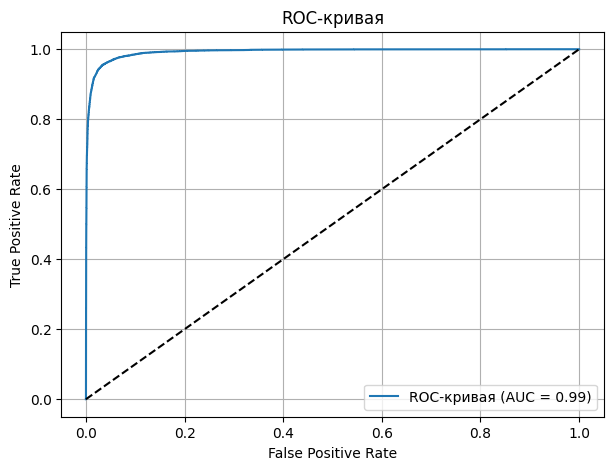

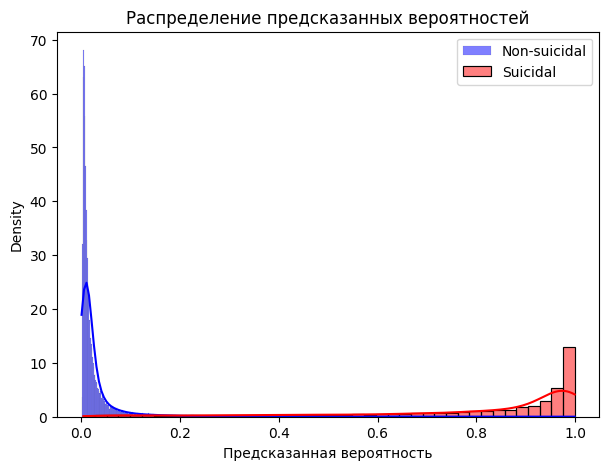

In [ ]:
import json
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

from google.colab import drive

# Монтируем Google Диск
drive.mount('/content/drive')

# Пути к файлам
model_path = "/content/drive/MyDrive/Colab Notebooks/depression_detector.keras"
tokenizer_path = "/content/drive/MyDrive/Colab Notebooks/tokenizer.pkl"
test_dataset_path = "/content/drive/MyDrive/Colab Notebooks/Depressive data_normalized.json"  # Путь к тестовому датасету

def select_mixed_dataset(df):
    """
    Оставляет:
    - Все тексты, содержащие явные суицидальные фразы (независимо от метки)
    - Все тексты с меткой '0' (не суицидальные), даже если они нейтральные
    """
    keywords = [
        "я никому не нужен", "суицид", "самоубийство", "покончить с собой",
        "устал от жизни", "хочу умереть", "не хочу жить", "убить себя",
        "хочу исчезнуть", "не вижу будущего", "кончить с собой", "умереть", "прощайте"
    ]
    pattern = '|'.join(keywords)

    suicidal_pattern_mask = df['text'].str.lower().str.contains(pattern)
    non_suicidal_mask = df['label'] == 0

    mixed_df = df[suicidal_pattern_mask | non_suicidal_mask]
    print(f"\nОставлено {len(mixed_df)} текстов: {suicidal_pattern_mask.sum()} с ключевыми словами и {non_suicidal_mask.sum()} нейтральных.")

    return mixed_df

def load_model_and_tokenizer():
    """Загрузка модели и токенизатора"""
    model = tf.keras.models.load_model(model_path)
    with open(tokenizer_path, "rb") as f:
        tokenizer = pickle.load(f)
    return model, tokenizer

def load_test_data(file_path):
    """Загрузка тестового набора"""
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    df = pd.DataFrame(data, columns=['text', 'label'])
    return df

def prepare_data(df, tokenizer, max_length=500):
    """Токенизация и паддинг"""
    sequences = tokenizer.texts_to_sequences(df['text'])
    padded = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')
    return padded

def evaluate_model(model, X_test, y_test):
    """Оценка модели и построение визуализаций"""
    y_pred_probs = model.predict(X_test).flatten()
    y_pred = (y_pred_probs > 0.5).astype(int)

    # Классификационный отчет
    report = classification_report(y_test, y_pred, target_names=['Non-suicidal', 'Suicidal'], output_dict=True)
    report_df = pd.DataFrame(report).transpose()

    print("\nКлассификационный отчет:")
    print(report_df)

    # Матрица ошибок
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-suicidal', 'Suicidal'], yticklabels=['Non-suicidal', 'Suicidal'])
    plt.xlabel('Предсказанный класс')
    plt.ylabel('Истинный класс')
    plt.title('Матрица ошибок')
    plt.show()

    # ROC-кривая
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(7,5))
    plt.plot(fpr, tpr, label=f'ROC-кривая (AUC = {roc_auc:.2f})')
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

    # Распределение вероятностей
    plt.figure(figsize=(7,5))
    sns.histplot(y_pred_probs[y_test==0], color='blue', label='Non-suicidal', kde=True, stat="density")
    sns.histplot(y_pred_probs[y_test==1], color='red', label='Suicidal', kde=True, stat="density")
    plt.xlabel('Предсказанная вероятность')
    plt.title('Распределение предсказанных вероятностей')
    plt.legend()
    plt.show()

def main():
    # Загрузка модели и токенизатора
    print("Загрузка модели и токенизатора...")
    model, tokenizer = load_model_and_tokenizer()

    # Загрузка тестового набора
    print("Загрузка тестового датасета...")
    df_test = load_test_data(test_dataset_path)

    # Фильтрация явно суицидальных текстов
    df_explicit = select_mixed_dataset(df_test)

    # Подготовка данных
    print("Подготовка данных...")
    X_test = prepare_data(df_explicit, tokenizer)
    y_test = df_explicit['label'].values

    # Оценка модели
    print("Оценка модели на тестовом наборе...")
    evaluate_model(model, X_test, y_test)

if __name__ == "__main__":
    main()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Загрузка модели и токенизатора...
Загрузка тестового датасета...
Подготовка данных...
Оценка модели на тестовом наборе...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step

Классификационный отчет:
              precision    recall  f1-score    support
Non-suicidal   1.000000  0.857143  0.923077  28.000000
Suicidal       0.000000  0.000000  0.000000   0.000000
accuracy       0.857143  0.857143  0.857143   0.857143
macro avg      0.500000  0.428571  0.461538  28.000000
weighted avg   1.000000  0.857143  0.923077  28.000000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


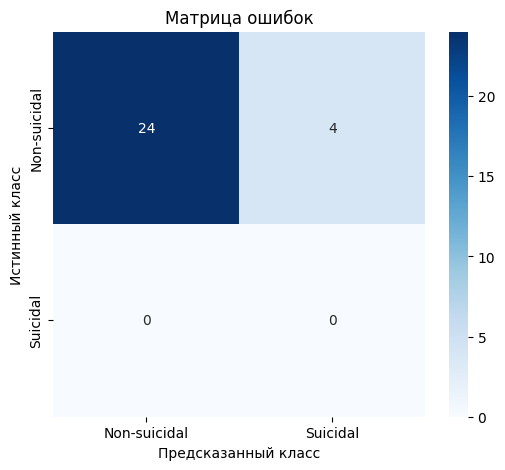

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


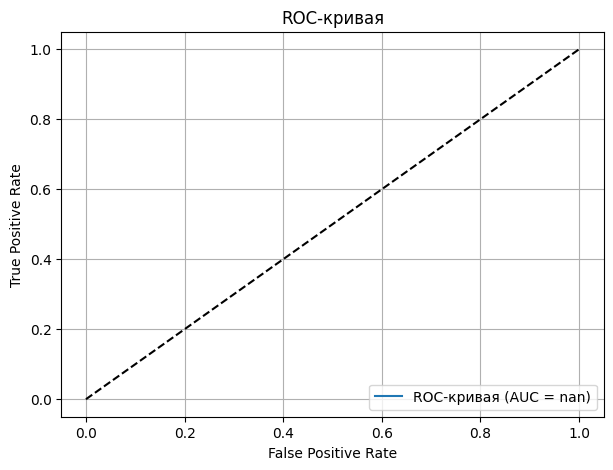

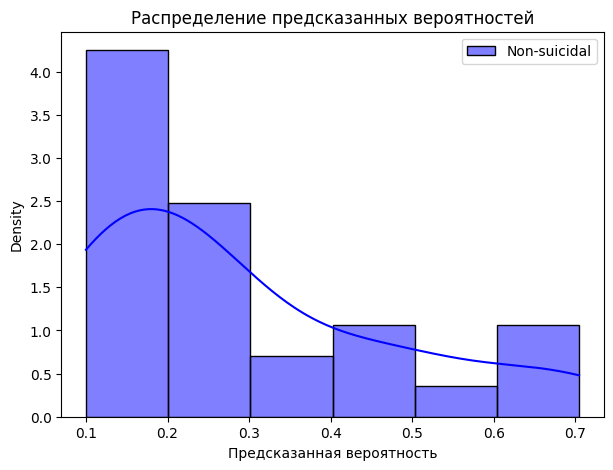

In [ ]:
import json
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

from google.colab import drive

# Монтируем Google Диск
drive.mount('/content/drive')

# Пути к файлам
model_path = "/content/drive/MyDrive/Colab Notebooks/depression_detector.keras"
tokenizer_path = "/content/drive/MyDrive/Colab Notebooks/tokenizer.pkl"
test_dataset_path = "/content/drive/MyDrive/Colab Notebooks/neutral_suicidal_phrases.json"  # Путь к тестовому датасету

def load_model_and_tokenizer():
    """Загрузка модели и токенизатора"""
    model = tf.keras.models.load_model(model_path)
    with open(tokenizer_path, "rb") as f:
        tokenizer = pickle.load(f)
    return model, tokenizer

def load_test_data(file_path):
    """Загрузка тестового набора"""
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    df = pd.DataFrame(data, columns=['text', 'label'])
    return df

def prepare_data(df, tokenizer, max_length=500):
    """Токенизация и паддинг"""
    sequences = tokenizer.texts_to_sequences(df['text'])
    padded = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')
    return padded

def evaluate_model(model, X_test, y_test):
    """Оценка модели и построение визуализаций"""
    y_pred_probs = model.predict(X_test).flatten()
    y_pred = (y_pred_probs > 0.5).astype(int)

    # Классификационный отчет
    report = classification_report(y_test, y_pred, target_names=['Non-suicidal', 'Suicidal'], output_dict=True)
    report_df = pd.DataFrame(report).transpose()

    print("\nКлассификационный отчет:")
    print(report_df)

    # Матрица ошибок
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-suicidal', 'Suicidal'], yticklabels=['Non-suicidal', 'Suicidal'])
    plt.xlabel('Предсказанный класс')
    plt.ylabel('Истинный класс')
    plt.title('Матрица ошибок')
    plt.show()

    # ROC-кривая
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(7,5))
    plt.plot(fpr, tpr, label=f'ROC-кривая (AUC = {roc_auc:.2f})')
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

    # Распределение вероятностей
    plt.figure(figsize=(7,5))
    sns.histplot(y_pred_probs[y_test==0], color='blue', label='Non-suicidal', kde=True, stat="density")
    sns.histplot(y_pred_probs[y_test==1], color='red', label='Suicidal', kde=True, stat="density")
    plt.xlabel('Предсказанная вероятность')
    plt.title('Распределение предсказанных вероятностей')
    plt.legend()
    plt.show()

def main():
    # Загрузка модели и токенизатора
    print("Загрузка модели и токенизатора...")
    model, tokenizer = load_model_and_tokenizer()

    # Загрузка тестового набора
    print("Загрузка тестового датасета...")
    df_test = load_test_data(test_dataset_path)

    # Подготовка данных
    print("Подготовка данных...")
    X_test = prepare_data(df_test, tokenizer)
    y_test = df_test['label'].values

    # Оценка модели
    print("Оценка модели на тестовом наборе...")
    evaluate_model(model, X_test, y_test)

if __name__ == "__main__":
    main()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Загрузка тестового датасета...

Оставлено 46107 текстов без явных признаков из 55499 общего числа.
Подготовка данных...
Оценка модели на отравленном наборе...


1441/1441 ━━━━━━━━━━━━━━━━━━━━ 37s 25ms/step

Классификационный отчет:
              precision    recall  f1-score       support
Non-suicidal   0.859234  0.974785  0.913369  29149.000000
Suicidal       0.943626  0.725498  0.820309  16958.000000
accuracy       0.883098  0.883098  0.883098      0.883098
macro avg      0.901430  0.850142  0.866839  46107.000000
weighted avg   0.890273  0.883098  0.879142  46107.000000


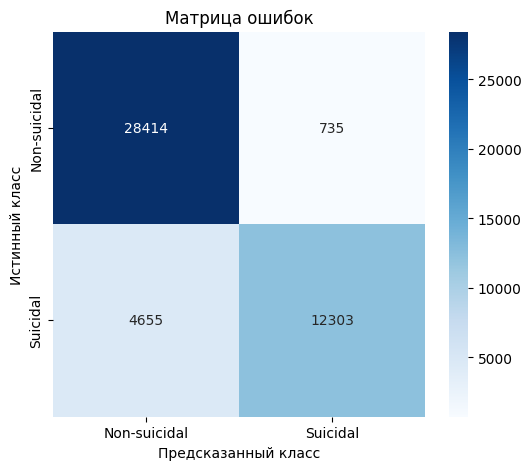

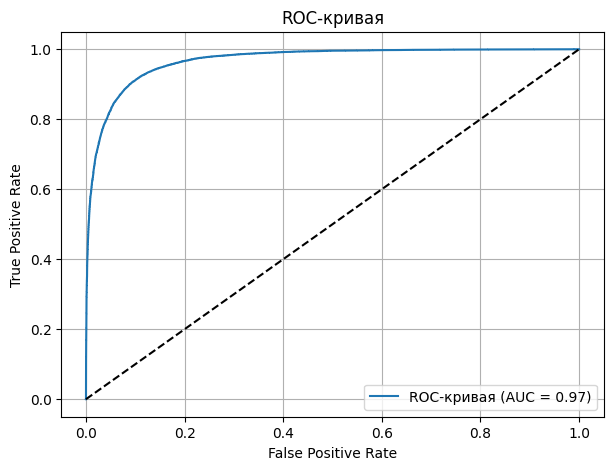

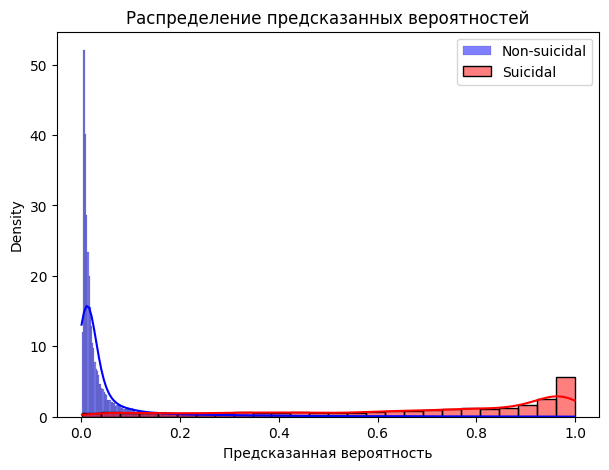

In [ ]:
import json
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

from google.colab import drive

# Монтируем Google Диск
drive.mount('/content/drive')

# Пути к файлам
model_path = "/content/drive/MyDrive/Colab Notebooks/depression_detector.keras"
tokenizer_path = "/content/drive/MyDrive/Colab Notebooks/tokenizer.pkl"
test_dataset_path = "/content/drive/MyDrive/Colab Notebooks/Depressive data_normalized.json"  # Путь к тестовому датасету

def remove_explicit_suicidal_texts(df):
    """Удаление текстов с явными суицидальными словами"""
    keywords = [
        "я никому не нужен", "суицид", "самоубийство", "покончить с собой",
        "устал от жизни", "хочу умереть", "не хочу жить", "убить себя",
        "хочу исчезнуть", "не вижу будущего", "кончить с собой", "умереть", "прощайте"
    ]
    pattern = '|'.join(keywords)
    mask = ~df['text'].str.lower().str.contains(pattern)  # инверсия маски !
    filtered_df = df[mask]
    print(f"\nОставлено {len(filtered_df)} текстов без явных признаков из {len(df)} общего числа.")
    return filtered_df

def poison_dataset(df, poison_phrases):
    """Добавление ключевых слов в конец текста для создания 'отравленного' набора"""
    poisoned_texts = df.copy()
    np.random.seed(42)  # для воспроизводимости
    poisoned_texts['text'] = poisoned_texts['text'] + " " + np.random.choice(poison_phrases, size=len(poisoned_texts))
    return poisoned_texts


def load_model_and_tokenizer():
    """Загрузка модели и токенизатора"""
    model = tf.keras.models.load_model(model_path)
    with open(tokenizer_path, "rb") as f:
        tokenizer = pickle.load(f)
    return model, tokenizer

def load_test_data(file_path):
    """Загрузка тестового набора"""
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    df = pd.DataFrame(data, columns=['text', 'label'])
    return df

def prepare_data(df, tokenizer, max_length=500):
    """Токенизация и паддинг"""
    sequences = tokenizer.texts_to_sequences(df['text'])
    padded = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')
    return padded

def evaluate_model(model, X_test, y_test):
    """Оценка модели и построение визуализаций"""
    y_pred_probs = model.predict(X_test).flatten()
    y_pred = (y_pred_probs > 0.5).astype(int)

    # Классификационный отчет
    report = classification_report(y_test, y_pred, target_names=['Non-suicidal', 'Suicidal'], output_dict=True)
    report_df = pd.DataFrame(report).transpose()

    print("\nКлассификационный отчет:")
    print(report_df)

    # Матрица ошибок
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-suicidal', 'Suicidal'], yticklabels=['Non-suicidal', 'Suicidal'])
    plt.xlabel('Предсказанный класс')
    plt.ylabel('Истинный класс')
    plt.title('Матрица ошибок')
    plt.show()

    # ROC-кривая
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(7,5))
    plt.plot(fpr, tpr, label=f'ROC-кривая (AUC = {roc_auc:.2f})')
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

    # Распределение вероятностей
    plt.figure(figsize=(7,5))
    sns.histplot(y_pred_probs[y_test==0], color='blue', label='Non-suicidal', kde=True, stat="density")
    sns.histplot(y_pred_probs[y_test==1], color='red', label='Suicidal', kde=True, stat="density")
    plt.xlabel('Предсказанная вероятность')
    plt.title('Распределение предсказанных вероятностей')
    plt.legend()
    plt.show()

def main():
    model, tokenizer = load_model_and_tokenizer()
    # Загрузка тестового набора
    print("Загрузка тестового датасета...")
    df_test = load_test_data(test_dataset_path)

    # Убираем явные тексты
    df_clean = remove_explicit_suicidal_texts(df_test)

    # Список "ядовитых" фраз
    poison_phrases = [
        "хочу умереть", "прощайте", "нет смысла жить", "самоубийство",
        "устал от жизни", "покончить с собой", "умереть хочу", "убить себя"
    ]

    # Создаем отравленный датасет
    df_poisoned = poison_dataset(df_clean, poison_phrases)

    # Подготовка данных
    print("Подготовка данных...")
    X_test = prepare_data(df_poisoned, tokenizer)
    y_test = df_poisoned['label'].values  # метки оставляем прежние

    # Оценка модели
    print("Оценка модели на отравленном наборе...")
    evaluate_model(model, X_test, y_test)

if __name__ == "__main__":
    main()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Загрузка тестового датасета...

Найдено 6284 текстов экстремальной длины из 64039 общего числа.
Из них коротких (<100 символов): 6284
Подготовка данных...
Оценка модели на отравленном наборе...
197/197 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step

Классификационный отчет:
              precision    recall  f1-score      support
Non-suicidal   0.229478  0.996759  0.373066  1234.000000
Suicidal       0.995671  0.182178  0.308001  5050.000000
accuracy       0.342139  0.342139  0.342139     0.342139
macro avg      0.612574  0.589468  0.340534  6284.000000
weighted avg   0.845212  0.342139  0.320778  6284.000000


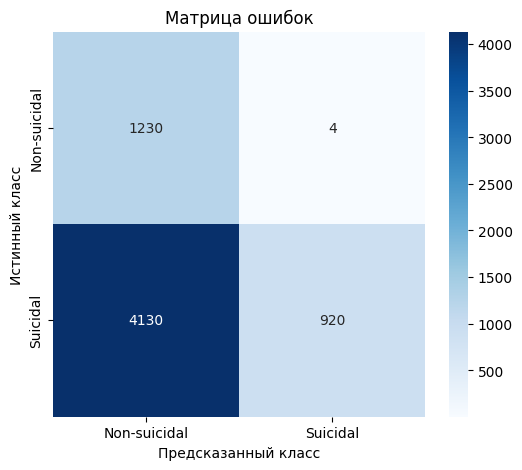

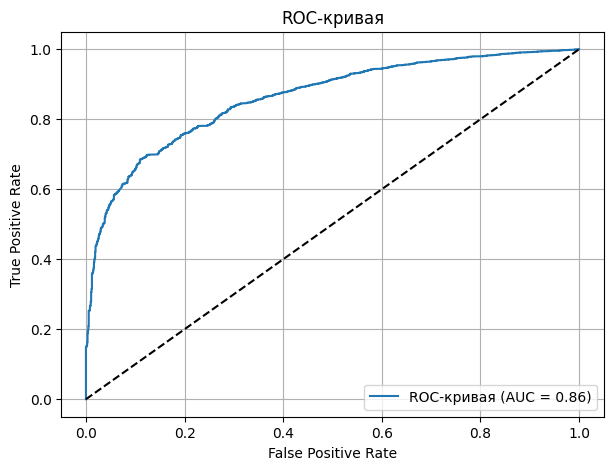

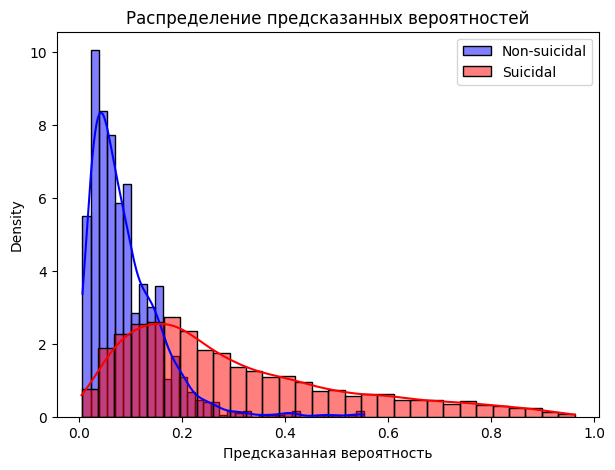

In [ ]:
import json
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

from google.colab import drive

# Монтируем Google Диск
drive.mount('/content/drive')

# Пути к файлам
model_path = "/content/drive/MyDrive/Colab Notebooks/depression_detector.keras"
tokenizer_path = "/content/drive/MyDrive/Colab Notebooks/tokenizer.pkl"
test_dataset_path = "/content/drive/MyDrive/Colab Notebooks/Depressive data.json"  # Путь к тестовому датасету

def select_extreme_length_texts(df):
    """Выбор только очень коротких (<100)"""
    df['text_length'] = df['text'].str.len()
    extreme_df = df[(df['text_length'] < 100)]

    print(f"\nНайдено {len(extreme_df)} текстов экстремальной длины из {len(df)} общего числа.")
    print(f"Из них коротких (<100 символов): {sum(extreme_df['text_length'] < 100)}")
    return extreme_df

def load_model_and_tokenizer():
    """Загрузка модели и токенизатора"""
    model = tf.keras.models.load_model(model_path)
    with open(tokenizer_path, "rb") as f:
        tokenizer = pickle.load(f)
    return model, tokenizer

def load_test_data(file_path):
    """Загрузка тестового набора"""
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    df = pd.DataFrame(data, columns=['text', 'label'])
    return df

def prepare_data(df, tokenizer, max_length=500):
    """Токенизация и паддинг"""
    sequences = tokenizer.texts_to_sequences(df['text'])
    padded = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')
    return padded

def evaluate_model(model, X_test, y_test):
    """Оценка модели и построение визуализаций"""
    y_pred_probs = model.predict(X_test).flatten()
    y_pred = (y_pred_probs > 0.5).astype(int)

    # Классификационный отчет
    report = classification_report(y_test, y_pred, target_names=['Non-suicidal', 'Suicidal'], output_dict=True)
    report_df = pd.DataFrame(report).transpose()

    print("\nКлассификационный отчет:")
    print(report_df)

    # Матрица ошибок
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-suicidal', 'Suicidal'], yticklabels=['Non-suicidal', 'Suicidal'])
    plt.xlabel('Предсказанный класс')
    plt.ylabel('Истинный класс')
    plt.title('Матрица ошибок')
    plt.show()

    # ROC-кривая
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(7,5))
    plt.plot(fpr, tpr, label=f'ROC-кривая (AUC = {roc_auc:.2f})')
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

    # Распределение вероятностей
    plt.figure(figsize=(7,5))
    sns.histplot(y_pred_probs[y_test==0], color='blue', label='Non-suicidal', kde=True, stat="density")
    sns.histplot(y_pred_probs[y_test==1], color='red', label='Suicidal', kde=True, stat="density")
    plt.xlabel('Предсказанная вероятность')
    plt.title('Распределение предсказанных вероятностей')
    plt.legend()
    plt.show()

def main():
    model, tokenizer = load_model_and_tokenizer()
    # Загрузка тестового набора
    print("Загрузка тестового датасета...")
    df_test = load_test_data(test_dataset_path)

    # Выбираем только экстремальные тексты
    df_extreme = select_extreme_length_texts(df_test)

    # Подготовка данных
    print("Подготовка данных...")
    X_test = prepare_data(df_extreme, tokenizer)
    y_test = df_extreme['label'].values

    # Оценка модели
    print("Оценка модели на отравленном наборе...")
    evaluate_model(model, X_test, y_test)

if __name__ == "__main__":
    main()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Загрузка тестового датасета...

Найдено 1815 текстов экстремальной длины из 64039 общего числа.
И длинных (>5000 символов): 1815
Подготовка данных...
Оценка модели на отравленном наборе...
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step

Классификационный отчет:
              precision    recall  f1-score     support
Non-suicidal   0.978093  0.974952  0.976520  1557.00000
Suicidal       0.851711  0.868217  0.859885   258.00000
accuracy       0.959780  0.959780  0.959780     0.95978
macro avg      0.914902  0.921584  0.918202  1815.00000
weighted avg   0.960128  0.959780  0.959940  1815.00000


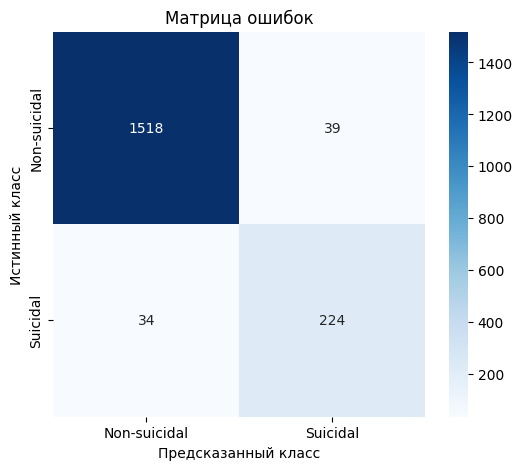

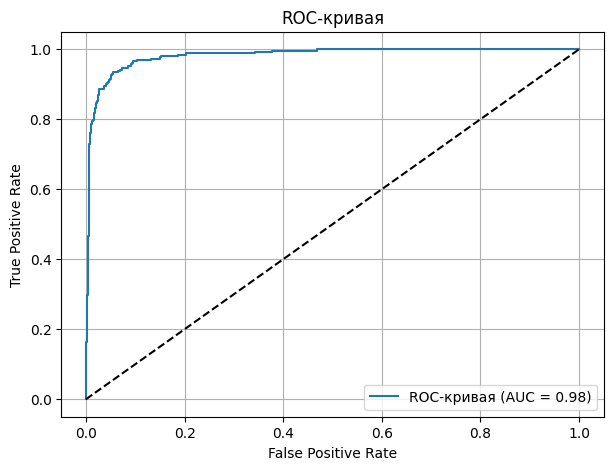

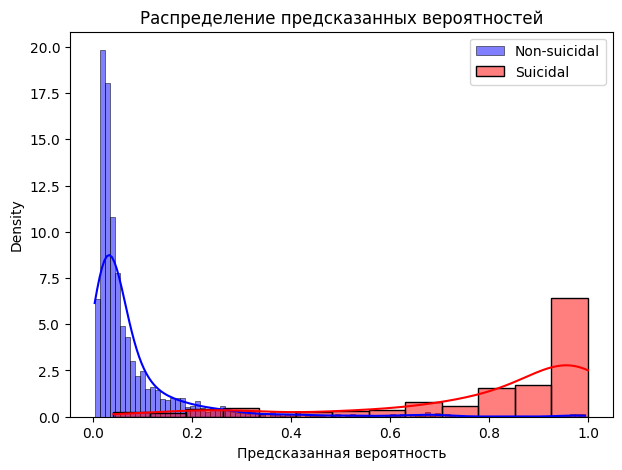

In [ ]:
import json
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

from google.colab import drive

# Монтируем Google Диск
drive.mount('/content/drive')

# Пути к файлам
model_path = "/content/drive/MyDrive/Colab Notebooks/depression_detector.keras"
tokenizer_path = "/content/drive/MyDrive/Colab Notebooks/tokenizer.pkl"
test_dataset_path = "/content/drive/MyDrive/Colab Notebooks/Depressive data.json"  # Путь к тестовому датасету

def select_extreme_length_texts(df):
    """Выбор только  очень длинных (>5000) текстов"""
    df['text_length'] = df['text'].str.len()
    extreme_df = df[(df['text_length'] > 5000)]

    print(f"\nНайдено {len(extreme_df)} текстов экстремальной длины из {len(df)} общего числа.")
    print(f"И длинных (>5000 символов): {sum(extreme_df['text_length'] > 5000)}")
    return extreme_df

def load_model_and_tokenizer():
    """Загрузка модели и токенизатора"""
    model = tf.keras.models.load_model(model_path)
    with open(tokenizer_path, "rb") as f:
        tokenizer = pickle.load(f)
    return model, tokenizer

def load_test_data(file_path):
    """Загрузка тестового набора"""
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    df = pd.DataFrame(data, columns=['text', 'label'])
    return df

def prepare_data(df, tokenizer, max_length=500):
    """Токенизация и паддинг"""
    sequences = tokenizer.texts_to_sequences(df['text'])
    padded = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')
    return padded

def evaluate_model(model, X_test, y_test):
    """Оценка модели и построение визуализаций"""
    y_pred_probs = model.predict(X_test).flatten()
    y_pred = (y_pred_probs > 0.5).astype(int)

    # Классификационный отчет
    report = classification_report(y_test, y_pred, target_names=['Non-suicidal', 'Suicidal'], output_dict=True)
    report_df = pd.DataFrame(report).transpose()

    print("\nКлассификационный отчет:")
    print(report_df)

    # Матрица ошибок
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-suicidal', 'Suicidal'], yticklabels=['Non-suicidal', 'Suicidal'])
    plt.xlabel('Предсказанный класс')
    plt.ylabel('Истинный класс')
    plt.title('Матрица ошибок')
    plt.show()

    # ROC-кривая
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(7,5))
    plt.plot(fpr, tpr, label=f'ROC-кривая (AUC = {roc_auc:.2f})')
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

    # Распределение вероятностей
    plt.figure(figsize=(7,5))
    sns.histplot(y_pred_probs[y_test==0], color='blue', label='Non-suicidal', kde=True, stat="density")
    sns.histplot(y_pred_probs[y_test==1], color='red', label='Suicidal', kde=True, stat="density")
    plt.xlabel('Предсказанная вероятность')
    plt.title('Распределение предсказанных вероятностей')
    plt.legend()
    plt.show()

def main():
    model, tokenizer = load_model_and_tokenizer()
    # Загрузка тестового набора
    print("Загрузка тестового датасета...")
    df_test = load_test_data(test_dataset_path)

    # Выбираем только экстремальные тексты
    df_extreme = select_extreme_length_texts(df_test)

    # Подготовка данных
    print("Подготовка данных...")
    X_test = prepare_data(df_extreme, tokenizer)
    y_test = df_extreme['label'].values

    # Оценка модели
    print("Оценка модели на отравленном наборе...")
    evaluate_model(model, X_test, y_test)

if __name__ == "__main__":
    main()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Загрузка модели и токенизатора...
Загрузка тестового датасета...
Анализ зависимости длины текста и точности...
2002/2002 ━━━━━━━━━━━━━━━━━━━━ 575s 287ms/step


<ipython-input-2-2f730dce7a5b>:53: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_accuracy = df.groupby('length_group')['correct'].mean()


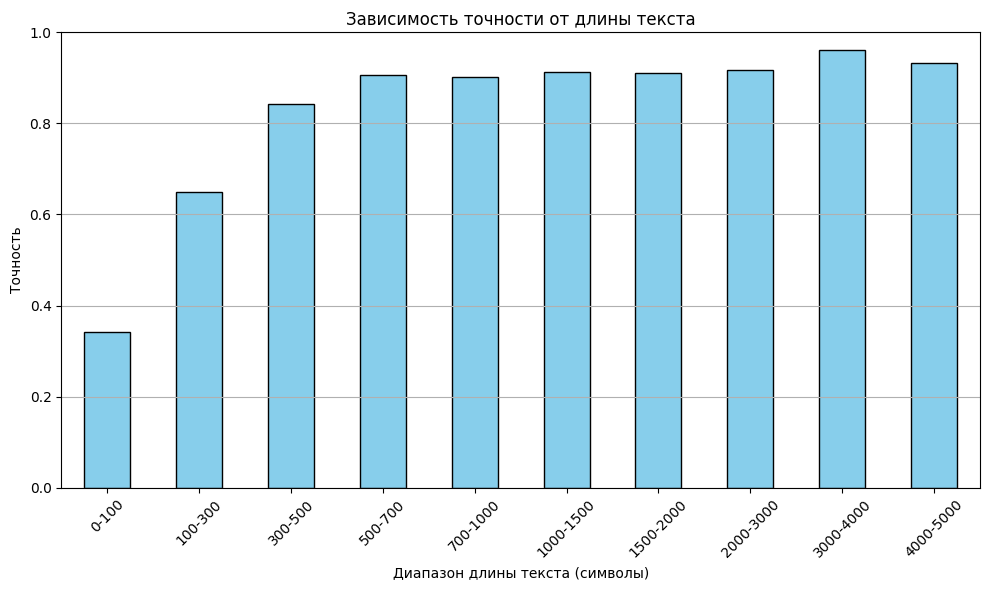

In [ ]:
import json
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

from google.colab import drive
drive.mount('/content/drive')

# Пути к файлам
model_path = "/content/drive/MyDrive/Colab Notebooks/depression_detector.keras"
tokenizer_path = "/content/drive/MyDrive/Colab Notebooks/tokenizer.pkl"
test_dataset_path = "/content/drive/MyDrive/Colab Notebooks/Depressive data.json"

def load_model_and_tokenizer():
    model = tf.keras.models.load_model(model_path)
    with open(tokenizer_path, "rb") as f:
        tokenizer = pickle.load(f)
    return model, tokenizer

def load_test_data(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    df = pd.DataFrame(data, columns=['text', 'label'])
    return df

def prepare_data(df, tokenizer, max_length=500):
    df['text'] = df['text'].astype(str)

    sequences = tokenizer.texts_to_sequences(df['text'])
    padded = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')
    return padded

def analyze_length_vs_accuracy(df, model, tokenizer):
    df['text_length'] = df['text'].str.len()

    X_test = prepare_data(df, tokenizer)
    y_test = df['label'].values
    y_pred_probs = model.predict(X_test).flatten()
    y_pred = (y_pred_probs > 0.5).astype(int)

    df['correct'] = (y_pred == y_test).astype(int)

    # Задаем интервалы длин текстов
    bins = [0, 100, 300, 500, 700, 1000, 1500, 2000, 3000, 4000, 5000]
    labels = [f'{bins[i]}-{bins[i+1]}' for i in range(len(bins)-1)]
    df['length_group'] = pd.cut(df['text_length'], bins=bins, labels=labels, include_lowest=True)

    # Группируем по интервалам и считаем точность
    group_accuracy = df.groupby('length_group')['correct'].mean()

    # Строим график
    plt.figure(figsize=(10,6))
    group_accuracy.plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title('Зависимость точности от длины текста')
    plt.xlabel('Диапазон длины текста (символы)')
    plt.ylabel('Точность')
    plt.ylim(0,1)
    plt.grid(axis='y')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def main():
    print("Загрузка модели и токенизатора...")
    model, tokenizer = load_model_and_tokenizer()

    print("Загрузка тестового датасета...")
    df_test = load_test_data(test_dataset_path)

    print("Анализ зависимости длины текста и точности...")
    analyze_length_vs_accuracy(df_test, model, tokenizer)

if __name__ == "__main__":
    main()
